In [1]:
%load_ext autoreload
%autoreload 2

import librosa
import librosa.display
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import IPython.display

In [33]:
audio, _ = librosa.load("./data/sentence.wav", sr=8000)

In [3]:
audio, _ = librosa.load("./data/ILoveKanye.mp3", sr=8000)

/Users/vaclav/prog/venv2/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [34]:
def play(audio, sr=8000):
    IPython.display.display(IPython.display.Audio(audio, rate=sr))

def specplot(audio, n_fft=512, sr=8000):
    S = librosa.stft(audio, n_fft=n_fft)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(S_db, y_axis="linear", sr=sr, n_fft=n_fft)

In [35]:
audio2 = scipy.signal.lfilter(np.array([1.0, -0.9]), 1, audio)

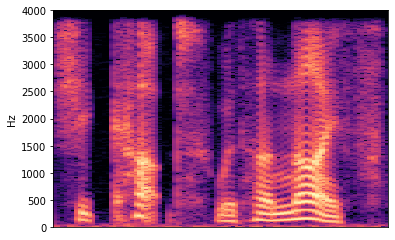

In [36]:
specplot(audio)

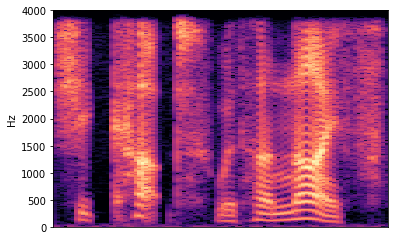

In [37]:
specplot(audio2)

In [38]:
play(audio)

In [39]:
play(audio2)

In [66]:
def lpcfit(x, p=12, h=128, w=None, ov=1):
    if w is None:
        w = 2 * h

    npts = len(x)
    nhops = npts // h

    # x = librosa.util.pad_center(x, size=np.ceil(len(x) / h) * h)
    # assert len(x) % h == 0
    x = np.concatenate([np.zeros((w - h) // 2), x, np.zeros((w - h) // 2)])

    a = np.zeros((nhops, p + 1))
    g = np.zeros(nhops)
    e = np.zeros((nhops - 1) * h + w)

    #     if ov == 0
    #   e = zeros(1, npts);
    # else
    #   e = zeros(1, (nhops-1)*h+w);
    # end

    x = scipy.signal.lfilter(np.array([1.0, -0.9]), 1, x)

    for hop in range(nhops):
        xx = x[hop * h : hop * h + w]
        wxx = xx * scipy.signal.get_window("hanning", w)

        rxx = scipy.signal.correlate(wxx, wxx)
        rxx = rxx[w - 1 : w + p]

        try:
            an = scipy.linalg.solve_toeplitz(rxx[:p], rxx[1 : p + 1])
        except scipy.linalg.LinAlgError:  # "Singular principal minor"
            continue
        # print(an.shape)

        aa = np.concatenate([[1], -an])
        rs = scipy.signal.lfilter(aa, 1, wxx)

        G = np.sqrt(np.mean(rs**2))
        a[hop] = aa
        g[hop] = G

        e[hop * h : hop * h + w] += rs / G
        # e((hop - 1)*h + [1:w]) =  e((hop - 1)*h + [1:w]) + rs/G;
        # break

    e = e[(w - h) // 2 :]

    return a, g, e


a, g, e = lpcfit(audio, p=8)

from sine_wave_speech.lpc import fit_lpc
a, g, e = fit_lpc(audio, p=8)

[ 1.          1.64427744  1.71212594  0.82612863 -0.1725522  -1.12434231
 -1.3938286  -1.07318828 -0.3854812 ]
[1.         2.3233904  3.43572638 3.74146428 3.18121871 2.02086407
 1.00606263 0.28517328 0.0885936 ]
[1.         2.23130233 3.25961485 3.32537211 2.74466227 1.74497821
 0.82192669 0.16218475 0.03599802]
[1.         2.38559045 3.59681184 3.84425531 3.3260341  2.23391638
 1.14982232 0.35501552 0.09402161]
[ 1.          1.92260205  2.27290698  1.57368015  0.49407948 -0.5107544
 -0.92164474 -0.74019023 -0.2653696 ]
[1.         2.05954188 3.11112802 3.39549125 2.97783802 2.10210299
 1.19118727 0.44344593 0.19548633]
[ 1.          1.01973029  0.92921808  0.04183824 -0.54542517 -0.82431246
 -0.57112323 -0.21352615  0.14712824]
[ 1.         -0.24475531  0.3966638  -0.94164803 -0.19847871 -0.4950073
  0.48505769  0.24990829  0.26158205]
[ 1.         -0.19906468  0.24840572 -0.90354746 -0.35436421 -0.42356374
  0.56755284  0.2117919   0.28733999]
[ 1.         -0.06191907  0.16294376 -0

In [ ]:
[ 2.97220959e-03 -1.90985098e-03 -6.11927759e-06  1.10940579e-03
 -1.12007028e-03  7.18634177e-04 -2.38064482e-04  6.24481418e-05
 -1.47116691e-04]
[ 0.01594952 -0.01

In [54]:
a

array([[ 1.00000000e+00,  1.64427744e+00,  1.71212594e+00,
         8.26128633e-01, -1.72552202e-01, -1.12434231e+00,
        -1.39382860e+00, -1.07318828e+00, -3.85481197e-01],
       [ 1.00000000e+00,  2.32339040e+00,  3.43572638e+00,
         3.74146428e+00,  3.18121871e+00,  2.02086407e+00,
         1.00606263e+00,  2.85173277e-01,  8.85936022e-02],
       [ 1.00000000e+00,  2.23130233e+00,  3.25961485e+00,
         3.32537211e+00,  2.74466227e+00,  1.74497821e+00,
         8.21926692e-01,  1.62184749e-01,  3.59980247e-02],
       [ 1.00000000e+00,  2.38559045e+00,  3.59681184e+00,
         3.84425531e+00,  3.32603410e+00,  2.23391638e+00,
         1.14982232e+00,  3.55015521e-01,  9.40216094e-02],
       [ 1.00000000e+00,  1.92260205e+00,  2.27290698e+00,
         1.57368015e+00,  4.94079482e-01, -5.10754399e-01,
        -9.21644738e-01, -7.40190229e-01, -2.65369603e-01],
       [ 1.00000000e+00,  2.05954188e+00,  3.11112802e+00,
         3.39549125e+00,  2.97783802e+00,  2.102102

In [44]:
def lpca2frq(a, g):
    nhops, p = a.shape

    f = np.zeros((nhops, (p - 1) // 2))
    m = np.zeros((nhops, (p - 1) // 2))

    for hop in range(nhops):
        aa = a[hop]
        G = g[hop]
        an = aa[1:p]
        rts = np.roots(np.concatenate([[1], an]))
        frqs = np.angle(rts)
        mags = G / (1 - np.abs(rts))
        
        ix = np.argsort(frqs)
        keep = frqs[ix] > 0
        ix = ix[keep]
        
#         assert len(ix) <= f.shape[1], f"{frqs=}"

        f[hop,:len(ix)] = frqs[ix][:f.shape[1]]
        m[hop,:len(ix)] = mags[ix][:f.shape[1]]
#         print(an)

        # if hop == 3:
        #     break

    return f, m

f, m = lpca2frq(a, g)
f = f*8000/(2*np.pi)

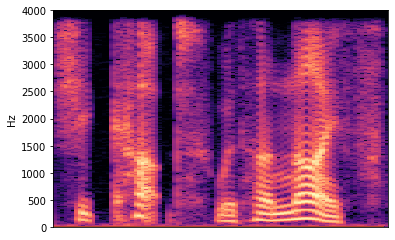

In [45]:
plt.plot(f[:100])
specplot(audio, n_fft=512)

In [46]:
def synthtrax(F, M, SR, SUBF=128, DUR=0):
    cols, rows = F.shape

    opsamps = round(DUR * SR)
    if DUR == 0:
        opsamps = 1 + (cols - 1) * SUBF

    X = np.zeros(opsamps)

    for row in range(rows):
        mm = M[:, row]
        ff = F[:, row]

        mm = np.nan_to_num(mm)
        ff = np.nan_to_num(ff)
        # assert np.sum(mm == 0) == 0

        nzcols = len(mm)

        def resample(x, factor):
            output_size = (len(mm) - 1) * factor + 1
            return np.interp(
                np.arange(output_size),
                np.arange(len(x)) * factor,
                x
            )

        ff = resample(ff, factor=SUBF)
        mm = resample(mm, factor=SUBF)
        
        pp = np.cumsum(2*np.pi*ff/SR)

        xx = mm * np.cos(pp)
#         xx = mm * scipy.signal.sawtooth(pp)
#         xx = mm * scipy.signal.square(pp)

        X += xx
#         break
    
    return X


X = synthtrax(f, m, SUBF=256, SR=8000)

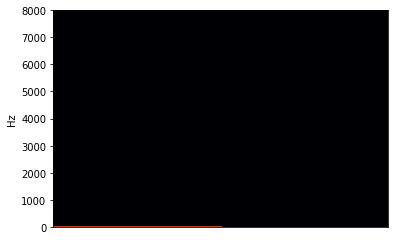

In [47]:
specplot(X, sr=16000)
plt.plot(f[:100])

In [48]:
play(X, sr=8000)

/Users/vaclav/prog/venv2/lib/python3.9/site-packages/IPython/lib/display.py:187: RuntimeWarning: invalid value encountered in true_divide
  scaled = data / normalization_factor * 32767


In [49]:
import sine_wave_speech.synthesis

In [50]:
play(sine_wave_speech.synthesis.synthesize(f, m, sr=8000), sr=8000)